# Time Series Part I: Estimation, Inference & Forecasting with ARMA

In [198]:
# load some useful libraries

import statsmodels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter 
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
import warnings
warnings.filterwarnings("ignore")

#### Part 1: Cleaning and Exploring the Covid-19 Data 

In [199]:
# Load the COVID-19 dataset
df = pd.read_csv('forecasts_and_truth.csv')

display(df.head())

,target_variable,target_end_date,location,location_name,temporal_resolution,population,geo_type,geo_value,abbreviation,full_location_name,...,type,forecast_value,truth_source,truth_value,abs_error,forecast_week,target_week,model_type,model_type.general,abs_error_per10k.pop
0,inc case,2020-04-11,01,Alabama,wk,4903185,state,al,AL,Alabama,...,point,920.0,Observed Data (NYTimes),1630,710.0,1,2,parametric-time.series-RW.first.difference,parametric-time.series,1.448038
1,inc case,2020-04-11,02,Alaska,wk,731545,state,ak,AK,Alaska,...,point,86.0,Observed Data (NYTimes),86,0.0,1,2,parametric-time.series-RW.first.difference,parametric-time.series,0.000000
2,inc case,2020-04-11,04,Arizona,wk,7278717,state,az,AZ,Arizona,...,point,1414.0,Observed Data (NYTimes),1374,40.0,1,2,parametric-time.series-RW.first.difference,parametric-time.series,0.054955
3,inc case,2020-04-11,05,Arkansas,wk,3017804,state,ar,AR,Arkansas,...,point,334.0,Observed Data (NYTimes),485,151.0,1,2,parametric-time.series-RW.first.difference,parametric-time.series,0.500364
4,inc case,2020-04-11,06,California,wk,39512223,state,ca,CA,California,...,point,7742.0,Observed Data (NYTimes),8625,883.0,1,2,parametric-time.series-RW.first.difference,parametric-time.series,0.223475


#### a) Load the data, filtering the dataset to focus exclusively on incident cases in the whole of the US. Ensure there are no duplicate rows in the resulting dataset. Plot the time series of cases. 

In [200]:
df = df[df['target_variable'] == 'inc case']
df = df[df['abbreviation'] == 'US']
df = df[['target_end_date','truth_value']].drop_duplicates()

display(df.head())

,target_end_date,truth_value
55,2020-04-11,218581
166,2020-04-18,201156
333,2020-04-25,211999
556,2020-05-02,194939
780,2020-05-09,177311


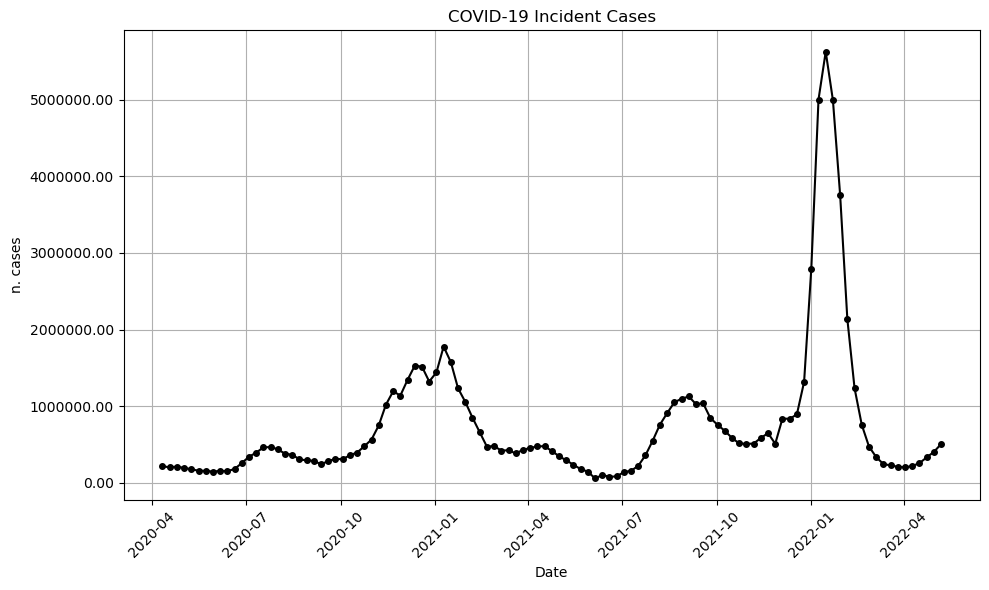

In [201]:
# Convert the 'target_end_date' column to datetime format
df['target_end_date'] = pd.to_datetime(df['target_end_date'])

# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(df['target_end_date'], df['truth_value'], marker='o', linestyle='-', color='black',markersize = '4')
plt.title('COVID-19 Incident Cases')
plt.xlabel('Date')
plt.ylabel('n. cases')
plt.grid(True)
# Manually format y-axis labels to avoid scientific notation
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### b) Does this data look stationary ? How could we transform the series to "encourage" compatibility with the stable-variance assumption necessary for time-series analysis ? Apply the transformation.

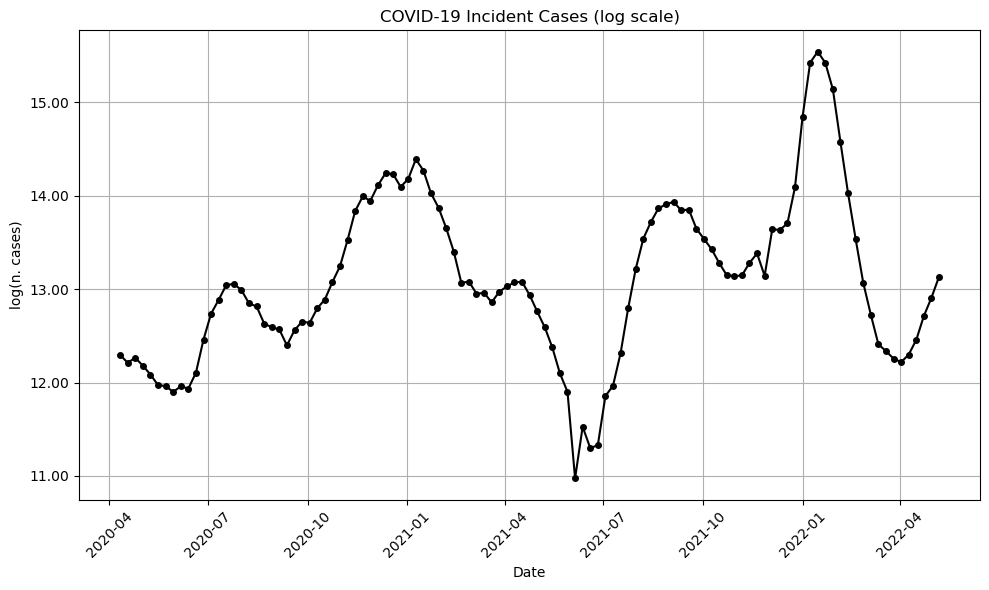

In [202]:
# You can take the log of the series. 
df['log_truth_value'] = np.log(df['truth_value'])

# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(df['target_end_date'], df['log_truth_value'], marker='o', linestyle='-', color='black',markersize = '4')
plt.title('COVID-19 Incident Cases (log scale)')
plt.xlabel('Date')
plt.ylabel('log(n. cases)')
plt.grid(True)
# Manually format y-axis labels to avoid scientific notation
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### c) Augment the series with the first 30 lags of the dependent varible. For each lag, calculate the pearson correlation with the most recent value. Plot this correlation again the order of the lag. 

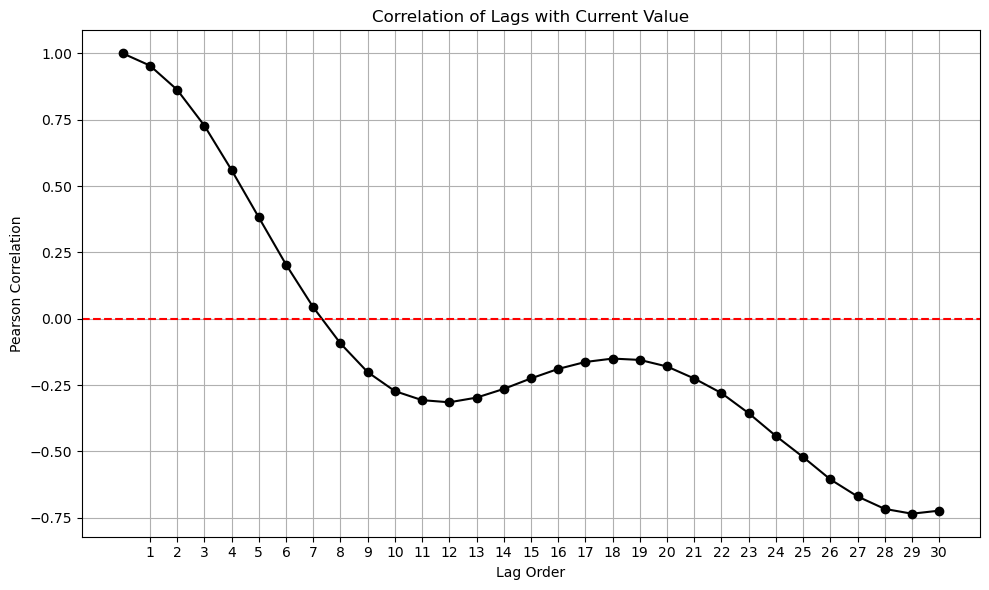

In [203]:
from scipy.stats import pearsonr

# Augment the series with the first 30 lags
lags = 30
for lag in range(0, lags + 1):
    df[f'lag_{lag}'] = df['log_truth_value'].shift(lag)

# Calculate the Pearson correlation for each lag
correlations = []
for lag in range(0, lags + 1):
    corr = pearsonr(df.dropna()['log_truth_value'], df.dropna()[f'lag_{lag}'])[0]
    correlations.append(corr)

# Plotting the correlation against the order of the lag
plt.figure(figsize=(10, 6))
plt.plot(range(0, lags + 1), correlations, marker='o', linestyle='-', color='black')
plt.axhline(y=0, color='r', linestyle='--')  
plt.title('Correlation of Lags with Current Value')
plt.xlabel('Lag Order')
plt.ylabel('Pearson Correlation')
plt.grid(True)
plt.xticks(range(1, lags + 1))
plt.tight_layout()
plt.show()

#### d) Interpret the plot. 

The plot displays a fairly typical behaviour of stationary time-series, namely some positive autocorrelation in the first few lags, and weaker autocorrelation at further lags. The positive lags-correlations imply today's log-number of cases are likely to be high when yesterday's were high, and vice-versa.

#### The above plot is called a `correlogram`. It is used to plot the autocorrelation function, which you have just done. The `statmodels` library has its own in-built functions for plotting this, along with another useful plot called the `partial autocorrelation function`. We will get to these in the 2nd time series workshop. 

<Figure size 1200x600 with 0 Axes>

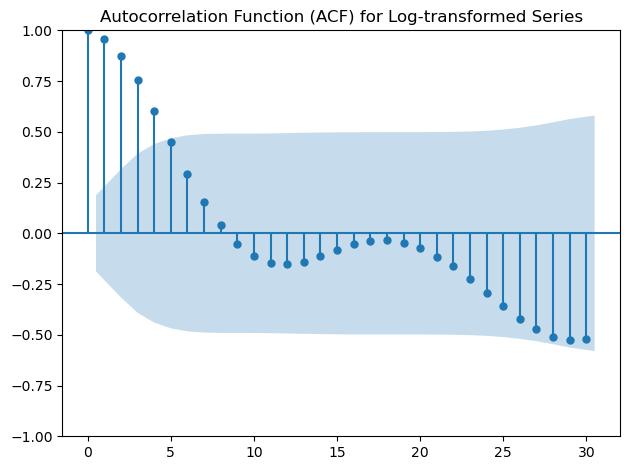

<Figure size 1200x600 with 0 Axes>

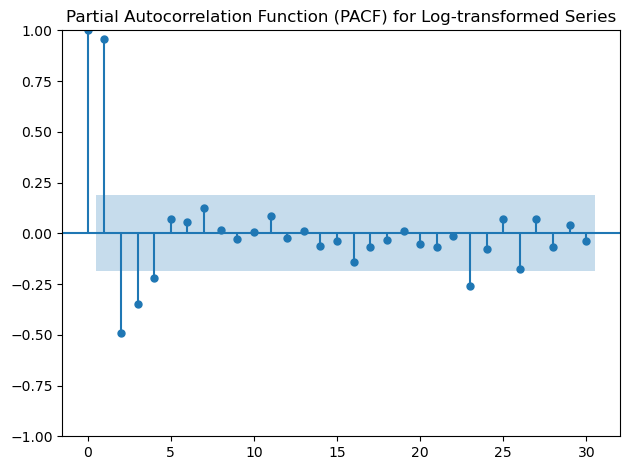

In [204]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotting the Autocorrelation Function (ACF)
plt.figure(figsize=(12, 6))
plot_acf(df['log_truth_value'].dropna(), lags=30, alpha=0.05, title='Autocorrelation Function (ACF) for Log-transformed Series')
plt.tight_layout()

# Plotting the Partial Autocorrelation Function (PACF)
plt.figure(figsize=(12, 6))
plot_pacf(df['log_truth_value'].dropna(), lags=30, alpha=0.05, title='Partial Autocorrelation Function (PACF) for Log-transformed Series')
plt.tight_layout()

plt.show()


#### Part II: Random Walks, Forecasts and Inference

#### a) Using a simple random walk, generate a forecast for the 365 days following the last available record in the dataset. Does this generate plausible predictions for the level of new covid cases ?

Note: due to the complicated nature of many-steps-ahead time-series forecasting, which can require stepwise prediction and re-calculation of fitted values, errors etc., we trust the ARIMA library from statmodels to generate multi-step prediction intervals. Note that this does not give us access to simulations for each forecast, and hence we have less flexibility. We will see how we can recover some of this flexibility in the following questions. Note that you `can` still do it the old fashioned way, but this is more straightforward and less messy. 

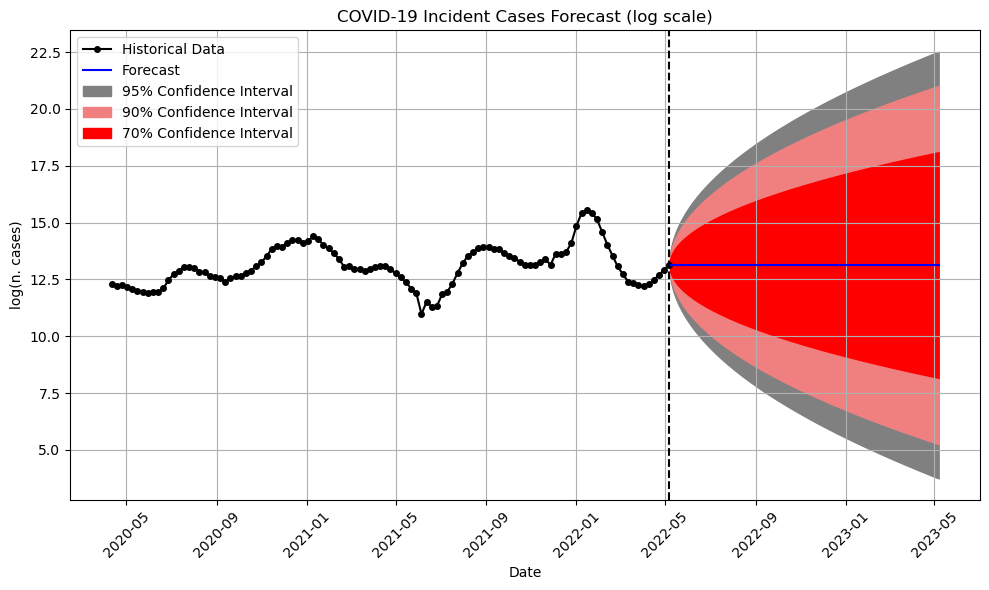

In [205]:
# Fit a simple ARIMA model (0,1,0) equivalent to a random walk
model = ARIMA(df['log_truth_value'], order=(0, 1, 0))
model_fit = model.fit()

# Forecast the next 365 days
forecast = model_fit.get_forecast(steps=365)

# Extract the forecast mean and confidence intervals
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int(alpha=0.05)  # 95% confidence interval

# Calculate the 70% and 90% confidence intervals
conf_int_70 = forecast.conf_int(alpha=0.30)  # 70% confidence interval
conf_int_90 = forecast.conf_int(alpha=0.10)  # 90% confidence interval

# Convert forecast index to match the dates if necessary
forecast_dates = pd.date_range(start=df['target_end_date'].iloc[-1] + pd.Timedelta(days=1), periods=365)

# Plot the historical data
plt.figure(figsize=(10, 6))
plt.plot(df['target_end_date'], df['log_truth_value'], marker='o', linestyle='-', color='black', markersize=4, label='Historical Data')

# Plot the forecast
plt.plot(forecast_dates, forecast_mean, color='blue', label='Forecast')

# Plot the confidence intervals
plt.fill_between(forecast_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='grey', alpha=1, label='95% Confidence Interval')
plt.fill_between(forecast_dates, conf_int_90.iloc[:, 0], conf_int_90.iloc[:, 1], color='lightcoral', alpha=1, label='90% Confidence Interval')
plt.fill_between(forecast_dates, conf_int_70.iloc[:, 0], conf_int_70.iloc[:, 1], color='red', alpha=1, label='70% Confidence Interval')

# Delineate the start of the forecast with a solid black line
plt.axvline(x=df['target_end_date'].iloc[-1], color='black', linestyle='--')

plt.title('COVID-19 Incident Cases Forecast (log scale)')
plt.xlabel('Date')
plt.ylabel('log(n. cases)')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

#### b) Now repeat the excercise with a random-walk with drift. 

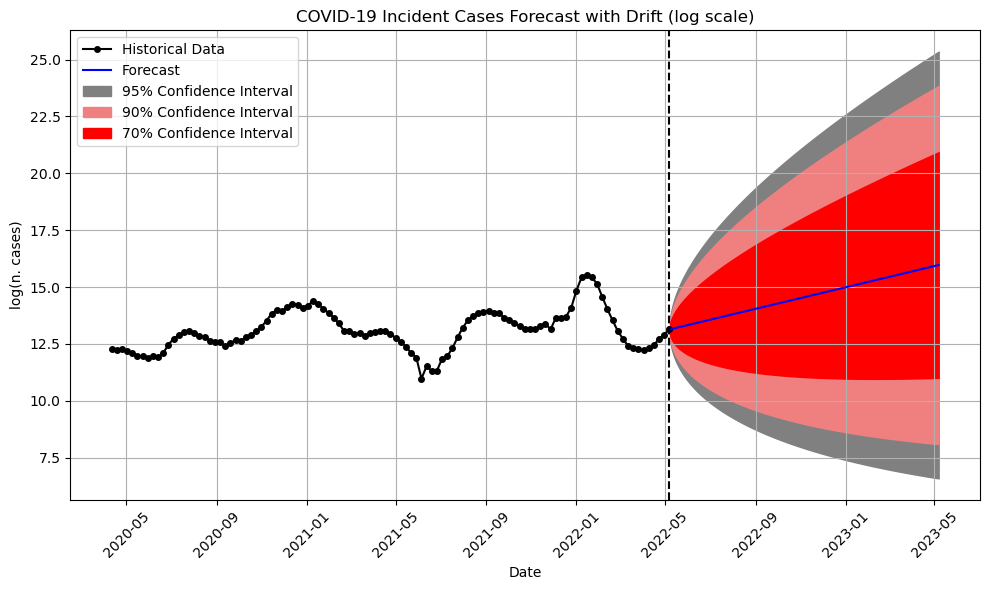

In [206]:
# Fit an ARIMA model (0,1,0) with a constant term to model a random walk with drift
model = ARIMA(df['log_truth_value'], order=(0, 1, 0), trend='t')
model_fit = model.fit()

# Forecast the next 52 weeks
forecast = model_fit.get_forecast(steps=365)

# Extract the forecast mean and confidence intervals
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int(alpha=0.05)  # 95% confidence interval

# Calculate the 70% and 90% confidence intervals
conf_int_70 = forecast.conf_int(alpha=0.30)  # 70% confidence interval
conf_int_90 = forecast.conf_int(alpha=0.10)  # 90% confidence interval

# Convert forecast index to match the dates if necessary
forecast_dates = pd.date_range(start=df['target_end_date'].iloc[-1] + pd.Timedelta(days=1), periods=365)

# Plot the historical data
plt.figure(figsize=(10, 6))
plt.plot(df['target_end_date'], df['log_truth_value'], marker='o', linestyle='-', color='black', markersize=4, label='Historical Data')

# Plot the forecast
plt.plot(forecast_dates, forecast_mean, color='blue', label='Forecast')

# Plot the confidence intervals
plt.fill_between(forecast_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='grey', alpha=1, label='95% Confidence Interval')
plt.fill_between(forecast_dates, conf_int_90.iloc[:, 0], conf_int_90.iloc[:, 1], color='lightcoral', alpha=1, label='90% Confidence Interval')
plt.fill_between(forecast_dates, conf_int_70.iloc[:, 0], conf_int_70.iloc[:, 1], color='red', alpha=1, label='70% Confidence Interval')


# Delineate the start of the forecast with a solid black line
plt.axvline(x=df['target_end_date'].iloc[-1], color='black', linestyle='--')

plt.title('COVID-19 Incident Cases Forecast with Drift (log scale)')
plt.xlabel('Date')
plt.ylabel('log(n. cases)')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

#### c) From the Random Walk with dirft that you just fit, using the fact that for a univariate random variable we can make inference simply by looking at its marginal distribution, assume a normal distribution and calculate the probability that there will be more than 5 million cases of covid one-year-on from the last observed case in the dataset. 

Hint: This requires you to first estimate the standard deviation of the posterior predictive distribution -- remember the 95% interval is the same as 1.96 standard deviations from the mean on each side for a normal distribution. Then simulate 10000 values from the normal with the ppoint estimate forecast value as the mean, and the estimated standard deviation. Then convert the log-values back to the original scale, and calculate the % of the simulated original-scale values that lie above 5 million. 

In [207]:
# Get the last row (which corresponds to the forecast interval you're interested in)
last_conf_int = conf_int.iloc[-1]

# Calculate the range by subtracting the lower limit from the upper limit
range_conf_int = last_conf_int['upper log_truth_value'] - last_conf_int['lower log_truth_value']

# Estimate the standard deviation by dividing the range by 4
estimated_std_dev = range_conf_int / 4

In [208]:
# Define n_simulations
n_simulations = 10000

# Simulating 10000 future log-values using the normal distribution
simulated_log_values = np.random.normal(loc=forecast_mean.iloc[-1], scale=estimated_std_dev, size=n_simulations)

# Convert the log-values back to the original scale
simulated_values = np.exp(simulated_log_values)

# Calculate the percentage of simulated values that are above 5 million
probability_above_5_million = (simulated_values > 5e6).mean()

probability_above_5_million

0.5421

#### d) Is the drift parameter statistically significant significant ? Answer this question by plotting the posterior density of the drift parameter. 

In [209]:
from scipy.stats import multivariate_normal, bernoulli, beta, norm

# Extract the coefficients (betas) and their covariance matrix from the logistic regression fit
beta_mean = model_fit.params
beta_cov = model_fit.cov_params()

# Simulate beta coefficients
simulated_betas = multivariate_normal.rvs(mean=beta_mean, cov=beta_cov, size=n_simulations)

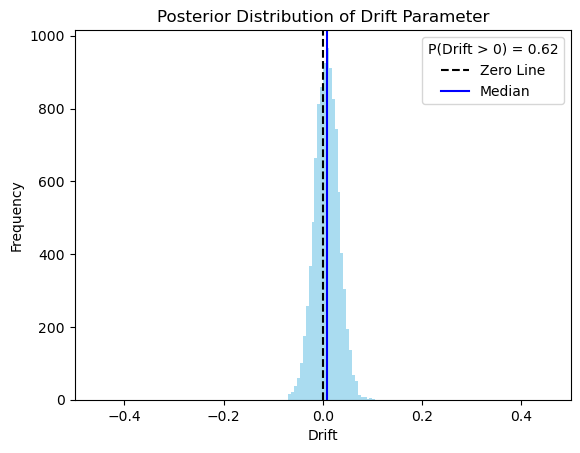

In [210]:
# Calculate the probability that the distribution is above 0
prob_above_0 = (simulated_betas[:, 0] > 0).mean()

plt.hist(simulated_betas[:, 0], bins=30, alpha=0.7,color = 'skyblue')
plt.axvline(0, color='k', linestyle='--', label='Zero Line')
plt.axvline(np.median(simulated_betas[:, 0]), color='blue', linestyle='-', label='Median')

plt.legend(title=f'P(Drift > 0) = {prob_above_0:.2f}')
plt.title("Posterior Distribution of Drift Parameter")
plt.xlabel("Drift")
plt.ylabel("Frequency")

# Ensure the range of x always includes 0
plt.xlim(min(-0.5, simulated_betas[:, 0].min()), max(0.5, simulated_betas[:, 0].max()))

plt.show()

#### Part III: Fitting ARIMA models.

#### a) Using the `auto_arima` function, detect the optimal number of AR and MA components necessary to model  the series. 

In [211]:
from pmdarima import auto_arima

# Detecting the optimal ARIMA parameters
model = auto_arima(df['log_truth_value'], start_p=0, start_q=0,
                   test='adf',       # Use adf test to find optimal 'd'
                   max_p=5, max_q=5, # Maximum p and q
                   m=1,              # Frequency of the series
                   d=None,           # Let the model determine 'd'
                   seasonal=False,   # No Seasonality
                   start_P=0, 
                   D=0, 
                   trace=True,
                   error_action='ignore',  
                   suppress_warnings=True, 
                   stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=872.429, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3.400, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-13.688, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-6.494, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-7.824, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-33.190, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-3.873, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-19.472, Time=0.01 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-35.426, Time=0.06 sec
 ARIMA(3,0,

#### b) Generate forecasts for the next year using this model. Display the 70, 90 and 95% intervals as before. 

In [212]:
# Extract the selected model order
order = model.order

In [213]:
# Non-seasonal ARIMA model
model = ARIMA(df['log_truth_value'], order=order)
model_fit = model.fit()

# Forecast the next 52 weeks
forecast = model_fit.get_forecast(steps=365)

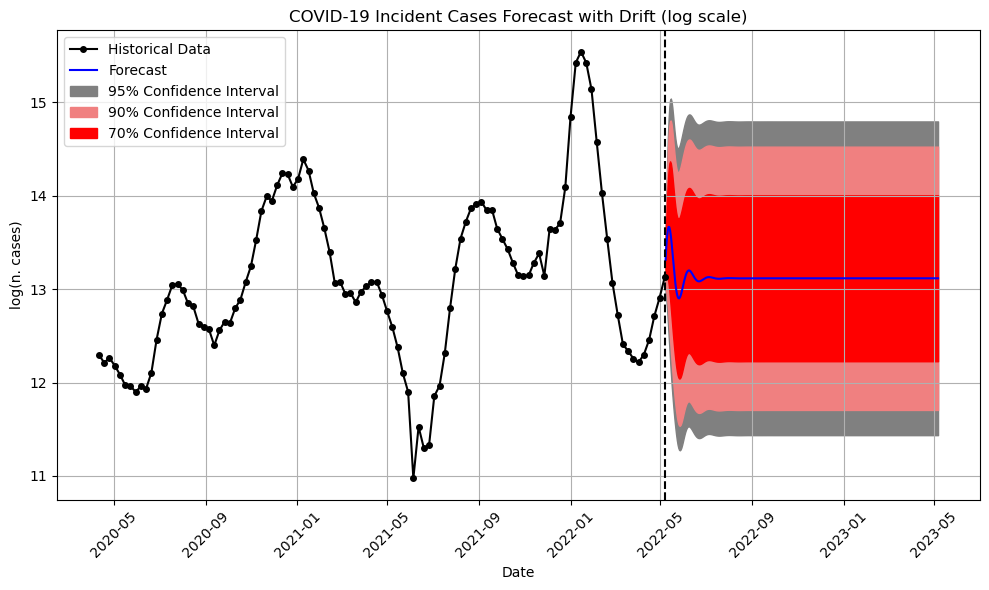

In [214]:
# Extract the forecast mean and confidence intervals
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int(alpha=0.05)  # 95% confidence interval

# Calculate the 70% and 90% confidence intervals
conf_int_70 = forecast.conf_int(alpha=0.30)  # 70% confidence interval
conf_int_90 = forecast.conf_int(alpha=0.10)  # 90% confidence interval

# Convert forecast index to match the dates if necessary
forecast_dates = pd.date_range(start=df['target_end_date'].iloc[-1] + pd.Timedelta(days=1), periods=365)

# Plot the historical data
plt.figure(figsize=(10, 6))
plt.plot(df['target_end_date'], df['log_truth_value'], marker='o', linestyle='-', color='black', markersize=4, label='Historical Data')

# Plot the forecast
plt.plot(forecast_dates, forecast_mean, color='blue', label='Forecast')

# Plot the confidence intervals
plt.fill_between(forecast_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='grey', alpha=1, label='95% Confidence Interval')
plt.fill_between(forecast_dates, conf_int_90.iloc[:, 0], conf_int_90.iloc[:, 1], color='lightcoral', alpha=1, label='90% Confidence Interval')
plt.fill_between(forecast_dates, conf_int_70.iloc[:, 0], conf_int_70.iloc[:, 1], color='red', alpha=1, label='70% Confidence Interval')


# Delineate the start of the forecast with a solid black line
plt.axvline(x=df['target_end_date'].iloc[-1], color='black', linestyle='--')

plt.title('COVID-19 Incident Cases Forecast with Drift (log scale)')
plt.xlabel('Date')
plt.ylabel('log(n. cases)')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

#### b) Now, using a temporally-aware cross-validation, get the point-estimate of the generalisation error of the selected model. Ensure you get the generalisation error on the origincal scale so that it is interpretable by policy makers. 

Note: Why must we make edits to traditional cross-validation ? Because we are not interested in `interpolation` but `extrapolation` -- so we want each fold to have a `future time` it has to forecast, rather than just random time points. 

In [225]:
# Using a manual function:

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

data = df['log_truth_value']  # Your time series data

n_splits = 10
total_size = len(data)
split_size = int(total_size / n_splits)  # Determining roughly equal-sized splits

scores = []

for split in range(1, n_splits + 1):
    
    # Calculate the index to split the data
    split_index = split_size * split
    
    # Ensure we do not go beyond the dataset's size
    # (this can happen due to the `roughly' equallty sized)
    if split_index > total_size:
        break
    
    # Splitting the data into training and test sets
    train, test = data[:split_index], np.exp(data[split_index:split_index + split_size])
    
    # Fit the selected model on the training data
    model = ARIMA(train, order = order)  
    model_fit = model.fit()
    
    # Forecast the next time steps equivalent to the size of the test set
    forecast = np.exp(model_fit.forecast(steps=len(test)))
    
    # Calculate and store the RMSE
    mse = mean_squared_error(test, forecast)
    rmse = np.sqrt(mse)  # Calculating RMSE
    scores.append(rmse)

# Calculate average RMSE
average_score = np.mean(scores)
print(f'Average RMSE: {average_score}')


Average RMSE: 591137.1996757337


#### c) This cross-validation method above provides a general estimate of the forecast error. But this is not so useful because we know many-steps-ahead forecasts will be worse than few-steps-ahead. Edit the above to use each cross-validation split to estimate up to 30 steps ahead worth of generalisation error. Store this in a new object. Plot this against the steps-ahead to see how the error can be expected to evolve over time. 

Note: there might not be enough observations to check 30 steps ahead in each fold -- check as many as you can ! 

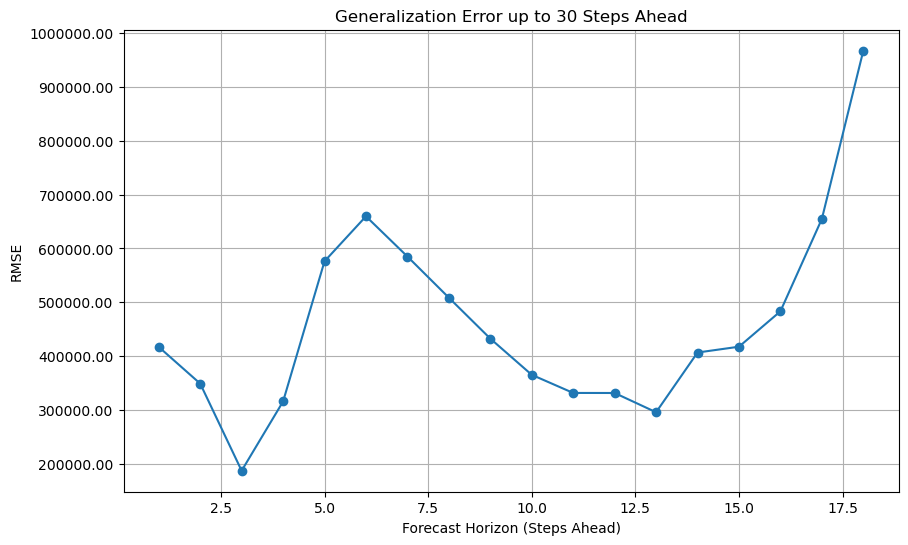

In [227]:
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import pandas as pd

data = df['log_truth_value']

n_splits = 5  # Define the number of splits for cross-validation
max_forecast_horizon = 30  # Maximum forecast horizon -- 
# note: In the dataset we have weekly readings. Here we are testing the accuracy of the forecasts
# for each of these readings, so the horizon is implicitly at the week-level. 
errors = []  # Using a list to collect arrays of varying lengths

tscv = TimeSeriesSplit(n_splits=n_splits)

for train_index, test_index in tscv.split(data):
    train, test = data.iloc[train_index], np.exp(data.iloc[test_index])
    available_forecast_horizon = min(len(test), max_forecast_horizon)
    
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    
    forecast = np.exp(model_fit.forecast(steps=available_forecast_horizon))
    true_values = test.iloc[:available_forecast_horizon].reset_index(drop=True)
    
    fold_errors = np.zeros(available_forecast_horizon)
    for step in range(available_forecast_horizon):
        # Ensuring correct indexing for both forecast and true_values
        # Convert forecast to a numpy array if it's not already one to standardize indexing
        forecast_values = np.array(forecast) if not isinstance(forecast, np.ndarray) else forecast
        mse = mean_squared_error([true_values.iloc[step]], [forecast_values[step]])
        rmse = np.sqrt(mse)
        fold_errors[step] = rmse
    
    errors.append(fold_errors)

# To handle varying lengths, we need to average errors for each step across all folds differently
max_length = max(len(e) for e in errors)  # Find the maximum forecast horizon across folds
average_errors = np.zeros(max_length)
for i in range(max_length):
    step_errors = [e[i] for e in errors if i < len(e)]  # Collect ith error from each fold if it exists
    average_errors[i] = np.mean(step_errors)  # Average those errors

# Plot the generalization error as a function of forecast horizon
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_length + 1), average_errors, marker='o')
plt.title('Generalization Error up to 30 Steps Ahead')
# Manually format y-axis labels to avoid scientific notation
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
plt.xlabel('Forecast Horizon (Steps Ahead)')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()


There are other ways to conduct this sort of generalisation error estimation -- see here for example: https://openforecast.org/adam/rollingOrigin.html